In [1]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


# Time Dependent Routing Algorithm for Flood Aware Routing Problem

by Jazzie R. Jao

In [2]:

import os
import random
import heapq

import numpy as np
import pandas as pd

import networkx as nx
import geopandas as gpd

from shapely.geometry import LineString
from shapely import wkt
from shapely.wkt import loads as wkt_loads

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colormaps

import contextily as ctx
import imageio


In [3]:
def build_graph_from_dataframe(df: pd.DataFrame) -> nx.Graph:
    G = nx.Graph()
    for _, row in df.iterrows():
        try:
            geometry = row['geometry']
            if isinstance(geometry, str):
                geometry = wkt.loads(geometry)
        except Exception:
            continue

        flood_series = [row[f'rr04-{str(i+1).zfill(2)}'] for i in range(60)]
        G.add_edge(
            row['u'], row['v'],
            length=row['length'],
            maxspeed=row['maxspeed_m'],
            geometry=geometry,
            oneway=row['oneway'],
            flood_levels=flood_series,
            elev=row.get('elev_mean', np.nan)
        )
    return G

In [ ]:


class FloodAwareRouter:
    """
    Time-aware flood routing for emergency vehicle navigation.
    Computes routes where flood conditions change dynamically as you traverse the network.
    """
    
    def __init__(self, df_edges: pd.DataFrame, G: nx.Graph, random_seed=None, 
                 threshold=0.1, alpha=0.3, lambda_tradeoff=0.5, risk_limit=1.0, 
                 animation_interval=600):
        """
        Initialize the router.
        
        Args:
            df_edges: DataFrame containing edge information with columns 'u', 'v'
            G: NetworkX graph with edge attributes:
                - length: Edge length in meters
                - maxspeed: Maximum speed in m/s
                - flood_levels: Array of flood levels over time (60 time steps)
                - elev_mean: Mean elevation (optional)
                - oneway: Binary flag for one-way streets (optional)
                - geometry: LineString geometry
            random_seed: Random seed for reproducibility
            threshold: Flood level threshold in meters (default: 0.1m)
            alpha: Speed reduction factor when flooded (default: 0.3 = 70% reduction)
            lambda_tradeoff: Weight for time vs risk (0=all risk, 1=all time, default: 0.5)
            risk_limit: Maximum acceptable cumulative risk (default: 1.0)
            animation_interval: Frame duration for animations in ms
        """
        self.df = df_edges.copy()
        self.G = G
        self.threshold = threshold
        self.alpha = alpha
        self.lambda_tradeoff = lambda_tradeoff
        self.risk_limit = risk_limit
        self.animation_interval = animation_interval
        self.required_edge = None
        self.depot = None

        if random_seed is not None:
            random.seed(random_seed)
            np.random.seed(random_seed)

    def _get_effective_speed(self, flood_level, speed):
        """Reduce speed if flood level exceeds threshold."""
        return self.alpha * speed if flood_level > self.threshold else speed

    def compute_edge_cost_at_time(self, u, v, current_time):
        """
        Compute edge cost, travel time, and risk at a specific time.
        
        Args:
            u, v: Edge endpoints
            current_time: Current time in seconds
            
        Returns:
            (cost, travel_time, risk)
        """
        # Ensure edge exists (handle undirected edges)
        if not self.G.has_edge(u, v):
            u, v = v, u
        
        edge = self.G[u][v]
        
        # Get edge attributes
        length = edge['length']
        speed = edge['maxspeed']
        elevation = edge.get('elev_mean', 0)
        
        # Get flood level at current time
        t_index = min(int(current_time // 60), 59)
        flood = edge['flood_levels'][t_index]
        
        # Calculate effective speed and travel time
        effective_speed = self._get_effective_speed(flood, speed)
        travel_time = length / effective_speed
        
        # Calculate risk components
        flood_component = min(flood / 1.5, 1.0)
        elev_component = 1 - np.tanh((elevation - flood * 10) / 100.0)
        exposure_component = min(travel_time / 180.0, 1.0)
        risk = flood_component * elev_component * exposure_component
        
        # Calculate cost (weighted combination of time and risk)
        cost = self.lambda_tradeoff * travel_time + (1 - self.lambda_tradeoff) * risk
        
        return cost, travel_time, risk

    def time_aware_shortest_path(self, source, target, start_time):
        """
        Find shortest path where edge costs depend on arrival time.
        Uses modified Dijkstra's algorithm with time tracking.
        
        Args:
            source: Starting node
            target: Destination node
            start_time: Starting time in seconds
            
        Returns:
            (path, total_cost, total_time, total_risk) or (None, inf, 0, 0) if no path found
        """
        # Priority queue: (total_cost, node, current_time, accumulated_risk, path)
        pq = [(0, source, start_time, 0, [source])]
        best_cost = {source: 0}
        visited = set()
        
        while pq:
            total_cost, current_node, current_time, accumulated_risk, path = heapq.heappop(pq)
            
            # Check if we've reached the target
            if current_node == target:
                total_time = current_time - start_time
                return path, total_cost, total_time, accumulated_risk
            
            # Create state identifier (node + time bucket to reduce state space)
            time_bucket = int(current_time // 60)
            state = (current_node, time_bucket)
            
            if state in visited:
                continue
            visited.add(state)
            
            # Explore neighbors
            for neighbor in self.G.neighbors(current_node):
                # Skip if risk limit would be exceeded
                if accumulated_risk > self.risk_limit:
                    continue
                
                # Compute edge cost at current arrival time
                edge_cost, travel_time, edge_risk = self.compute_edge_cost_at_time(
                    current_node, neighbor, current_time
                )
                
                new_cost = total_cost + edge_cost
                new_time = current_time + travel_time
                new_risk = accumulated_risk + edge_risk
                
                # Check risk limit
                if new_risk > self.risk_limit:
                    continue
                
                # Check if this is a better path to neighbor
                if neighbor not in best_cost or new_cost < best_cost[neighbor]:
                    best_cost[neighbor] = new_cost
                    new_path = path + [neighbor]
                    heapq.heappush(pq, (new_cost, neighbor, new_time, new_risk, new_path))
        
        # No path found
        return None, float('inf'), 0, 0

    def time_aware_routing(self, global_start_time=0):
        """
        Compute time-aware route from depot to required edge and back.
        Flood conditions change dynamically as you traverse the network.
        
        Args:
            global_start_time: Starting time in seconds
            
        Returns:
            List of node IDs representing the route, or empty list if no valid route found
        """
        u, v = self.required_edge
        oneway = self.G[u][v].get('oneway', 0)
        
        best_route = []
        best_cost = float('inf')
        
        if oneway == 1:
            # Must traverse u → v (one-way constraint)
            path1, cost1, time1, risk1 = self.time_aware_shortest_path(
                self.depot, u, global_start_time
            )
            
            if path1 is None:
                return []
            
            # Calculate arrival time at u
            arrival_at_u = global_start_time + time1
            
            # Traverse the required edge u → v
            t_index = min(int(arrival_at_u // 60), 59)
            edge = self.G[u][v]
            flood = edge['flood_levels'][t_index]
            length = edge['length']
            speed = edge['maxspeed']
            effective_speed = self._get_effective_speed(flood, speed)
            edge_time = length / effective_speed
            
            # Calculate arrival time at v
            arrival_at_v = arrival_at_u + edge_time
            
            # Find path from v back to depot
            path2, cost2, time2, risk2 = self.time_aware_shortest_path(
                v, self.depot, arrival_at_v
            )
            
            if path2 is not None:
                # Combine paths (avoid duplicate node v)
                best_route = path1 + [v] + path2[1:]
        
        else:
            # Two-way street: try both directions
            for start_node, end_node in [(u, v), (v, u)]:
                # Path to start node
                path1, cost1, time1, risk1 = self.time_aware_shortest_path(
                    self.depot, start_node, global_start_time
                )
                
                if path1 is None:
                    continue
                
                # Calculate arrival time
                arrival_at_start = global_start_time + time1
                
                # Traverse the required edge
                t_index = min(int(arrival_at_start // 60), 59)
                edge = self.G[start_node][end_node]
                flood = edge['flood_levels'][t_index]
                length = edge['length']
                speed = edge['maxspeed']
                effective_speed = self._get_effective_speed(flood, speed)
                edge_time = length / effective_speed
                
                arrival_at_end = arrival_at_start + edge_time
                
                # Path from end node back to depot
                path2, cost2, time2, risk2 = self.time_aware_shortest_path(
                    end_node, self.depot, arrival_at_end
                )
                
                if path2 is not None:
                    total_cost = cost1 + cost2
                    # Keep the better route
                    if total_cost < best_cost:
                        best_cost = total_cost
                        best_route = path1 + [end_node] + path2[1:]
        
        return best_route

    def export_route_metrics(self, route, filename='route_metrics.csv', global_start_time=0):
        """
        Export detailed route metrics to CSV and GeoJSON with time progression.
        
        Args:
            route: List of node IDs representing the path
            filename: Output CSV filename
            global_start_time: Starting time in seconds
        """
        if not route or len(route) < 2:
            print("No route to export.")
            return

        metrics = []
        current_time = global_start_time
        total_risk = 0
        flood_segments = 0
        total_flood = 0

        for i in range(len(route) - 1):
            u_raw, v_raw = route[i], route[i + 1]
            u, v = sorted([u_raw, v_raw])
            
            if not self.G.has_edge(u, v):
                print(f"⚠️ Edge ({u}, {v}) not found.")
                continue

            edge = self.G[u][v]
            
            # Use current_time for this edge
            t = min(int(current_time // 60), 59)
            flood = edge['flood_levels'][t]
            cost, travel_time, risk = self.compute_edge_cost_at_time(u_raw, v_raw, current_time)

            # Update accumulated values
            total_risk += risk
            total_flood += flood
            if flood > self.threshold:
                flood_segments += 1

            metrics.append({
                'from': u_raw,
                'to': v_raw,
                'arrival_time': current_time,
                'time_index': t,
                'length': edge['length'],
                'maxspeed': edge['maxspeed'],
                'flood_level': flood,
                'effective_time': travel_time,
                'risk': risk,
                'cost': cost,
                'geometry': edge['geometry'] if isinstance(edge['geometry'], LineString) else None
            })
            
            # Advance time for next edge
            current_time += travel_time

        # Export to files
        df_metrics = pd.DataFrame(metrics)
        gdf_metrics = gpd.GeoDataFrame(df_metrics, geometry='geometry', crs='EPSG:4326')
        gdf_metrics.to_file(filename.replace('.csv', '.geojson'), driver='GeoJSON')
        gdf_metrics.to_csv(filename, index=False)

        # Print summary
        total_time = current_time - global_start_time
        print(f"\n📤 Route Exported → {filename}")
        print(f"   Total Travel Time: {total_time:.2f} sec ({total_time/60:.1f} min)")
        print(f"   Total Flood Risk: {total_risk:.3f}")
        print(f"   Flooded Segments: {flood_segments}/{len(metrics)}")
        print(f"   Cumulative Flood Level: {total_flood:.2f} m")

    def _route_visits_required(self, route):
        """Check if route traverses the required edge (in any direction)."""
        if not route:
            return False
        u_req, v_req = self.required_edge
        for u, v in zip(route, route[1:]):
            if {u, v} == {u_req, v_req}:
                return True
        return False

    def is_route_continuous(self, route):
        """Validate that route forms a continuous path through the graph."""
        if not route or len(route) < 2:
            print("   Route too short to validate.")
            return False

        # Check all edges exist
        for i in range(len(route) - 1):
            u, v = route[i], route[i + 1]
            if not self.G.has_edge(u, v) and not self.G.has_edge(v, u):
                print(f"   ❌ Disconnected segment: ({u}, {v}) not found in graph.")
                return False
        
        # Check continuity (consecutive nodes match)
        for i in range(len(route) - 2):
            if route[i + 1] != route[i + 1]:  # Should always be true
                print(f"   ❌ Discontinuous step at position {i}")
                return False
        
        print("   ✓ Route is continuous.")
        return True

    def visualize_route_as_gif(self, route_gdf: gpd.GeoDataFrame, full_network_df: pd.DataFrame, 
                               filename='route_animation.gif', global_start_time=0):
        """
        Create animated GIF showing route progression with dynamic flood visualization.
        
        Args:
            route_gdf: GeoDataFrame with route segments and metrics
            full_network_df: DataFrame with full road network and flood data
            filename: Output GIF filename
            global_start_time: Starting time in seconds
        """
        # Load geometries if needed
        if route_gdf.geometry.dtype == 'object':
            route_gdf['geometry'] = route_gdf['geometry'].apply(wkt.loads)
        if full_network_df['geometry'].dtype == 'object':
            full_network_df['geometry'] = full_network_df['geometry'].apply(wkt.loads)

        # Convert to proper CRS
        gdf_route = gpd.GeoDataFrame(route_gdf, geometry='geometry', crs='EPSG:3857')
        gdf_streets = gpd.GeoDataFrame(full_network_df, geometry='geometry', crs='EPSG:3857')

        # Set bounds with padding
        bounds = gdf_route.total_bounds
        xpad = (bounds[2] - bounds[0]) * 0.05
        ypad = (bounds[3] - bounds[1]) * 0.05
        bbox = [bounds[0] - xpad, bounds[1] - ypad, bounds[2] + xpad, bounds[3] + ypad]

        # Create frames directory
        output_dir = 'frames'
        os.makedirs(output_dir, exist_ok=True)
        frame_paths = []
        cumulative_flood = 0
        time_elapsed = 0

        # Generate frames
        for i, row in gdf_route.iterrows():
            cumulative_flood += row['flood_level']
            time_elapsed += row['effective_time']
            current_time = global_start_time + time_elapsed
            time_index = min(int(current_time // 60), 59)
            flood_col = f'rr04-{str(time_index + 1).zfill(2)}'

            if flood_col not in gdf_streets.columns:
                print(f"⚠️ Missing flood column: {flood_col}")
                continue

            # Update network flood levels
            gdf_streets['flood_level_now'] = gdf_streets[flood_col]
            norm = Normalize(vmin=0, vmax=0.5)
            cmap = colormaps['Blues']

            # Get current route segment
            current_segment = gdf_route.iloc[:i + 1]
            valid_segment = current_segment[
                current_segment['geometry'].notnull() & current_segment['geometry'].is_valid
            ]
            if valid_segment.empty:
                continue

            # Create figure
            fig, ax = plt.subplots(figsize=(12, 12))

            # Draw network with flood coloring
            for _, edge in gdf_streets.iterrows():
                if edge['geometry'] is None or not edge['geometry'].is_valid:
                    continue
                color = cmap(norm(edge['flood_level_now']))
                ax.plot(*edge['geometry'].xy, color=color, linewidth=1.2, alpha=0.6)

            # Draw route
            valid_segment.plot(ax=ax, linewidth=3, color='blue', alpha=0.9)

            # Draw current position
            geom = row['geometry']
            if geom is not None and geom.is_valid:
                pt = geom.interpolate(0.5, normalized=True)
                gpd.GeoSeries([pt], crs='EPSG:3857').plot(ax=ax, color='red', markersize=80)

            # Title with metrics
            ax.set_title(
                f"Step {i + 1}/{len(gdf_route)} | Flood: {row['flood_level']:.3f} m | "
                f"Accum: {cumulative_flood:.3f} m\n"
                f"Time: {int(current_time)}s ({current_time/60:.1f}min) | "
                f"Start: {int(global_start_time)}s | Index: {time_index + 1}",
                fontsize=13
            )

            ax.set_xlim(bbox[0], bbox[2])
            ax.set_ylim(bbox[1], bbox[3])
            ax.axis('off')

            # Add basemap
            try:
                ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
            except Exception as e:
                print(f"⚠️ Basemap failed: {e}")

            # Save frame
            frame_path = os.path.join(output_dir, f"frame_{i:03}.png")
            plt.savefig(frame_path, bbox_inches='tight')
            plt.close()
            frame_paths.append(frame_path)

        # Create GIF
        with imageio.get_writer(filename, mode='I', duration=self.animation_interval / 1000) as writer:
            for f in frame_paths:
                writer.append_data(imageio.imread(f))

        # Cleanup frames
        for f in frame_paths:
            os.remove(f)

        print(f"🎞️ Route animation saved as: {filename}")

    def run_all(self, global_start_time=0, export_prefix='output'):
        """
        Execute complete routing workflow with time-aware routing.
        
        Args:
            global_start_time: Starting time in seconds
            export_prefix: Prefix for output files
        """
        print(f"\n{'='*60}")
        print(f"FLOOD-AWARE ROUTING (TIME-AWARE)")
        print(f"{'='*60}")
        print(f"⏱️ Starting time: {global_start_time}s ({global_start_time/60:.1f} min)")

        # Select random depot and required edge
        self.required_edge = tuple(self.df.sample(1)[['u', 'v']].values[0])
        self.depot = random.choice(list(self.G.nodes))
        print(f"🏁 Depot node: {self.depot}")
        print(f"📍 Required edge: {self.required_edge}")

        # Compute shortest path (for comparison)
        print(f"\n{'='*60}")
        print("Computing shortest path (length-based)...")
        try:
            u, v = self.required_edge
            sp_core = nx.shortest_path(self.G, source=self.depot, target=u, weight='length')
            sp_mid = [v] if u != v else []
            sp_path = sp_core + sp_mid + list(reversed(sp_core))
            print(f"Shortest path found: {len(sp_path)} nodes")
        except Exception as e:
            print(f"Shortest path failed: {e}")
            sp_path = []

        # Compute time-aware flood-aware path
        print(f"\n{'='*60}")
        print("Computing time-aware flood-aware path...")
        fa_path = self.time_aware_routing(global_start_time=global_start_time)
        if fa_path:
            print(f"Time-aware path found: {len(fa_path)} nodes")
        else:
            print(f"No valid time-aware path found (check risk_limit)")

        # Export routes
        print(f"\n{'='*60}")
        print("Exporting route metrics...")
        self.export_route_metrics(
            sp_path, 
            filename=f'{export_prefix}_shortest.csv', 
            global_start_time=global_start_time
        )
        self.export_route_metrics(
            fa_path, 
            filename=f'{export_prefix}_floodaware.csv', 
            global_start_time=global_start_time
        )

        # Validate routes
        print(f"\n{'='*60}")
        print("Validating routes...")
        print("\nShortest path:")
        if self._route_visits_required(sp_path):
            print("Visits required edge")
        else:
            print("Does NOT visit required edge")
        self.is_route_continuous(sp_path)

        print("\nTime-aware flood-aware path:")
        if self._route_visits_required(fa_path):
            print("Visits required edge")
        else:
            print("Does NOT visit required edge")
        self.is_route_continuous(fa_path)

        print(f"\n{'='*60}")
        print("Routing complete!")
        print(f"{'='*60}\n")

In [ ]:

def run_experiment_batch(df, num_trials=10, output_dir='batch_results',
                         seeds=None, global_times=None, lambda_tradeoff=0.5,
                         alpha=0.3, threshold=0.1, risk_limit=1.0):
    """
    Run batch experiments with time-aware flood routing.
    
    Args:
        df: DataFrame with edge data including flood_levels
        num_trials: Number of experiment runs
        output_dir: Directory for outputs
        seeds: List of random seeds (generated if None)
        global_times: List of start times in seconds (generated if None)
        lambda_tradeoff: Balance between time (high) and risk (low), default: 0.5
        alpha: Speed reduction factor during floods, default: 0.3
        threshold: Flood level threshold in meters, default: 0.1
        risk_limit: Maximum acceptable cumulative risk, default: 1.0
    
    Returns:
        DataFrame with summary of all trials
    """
    os.makedirs(output_dir, exist_ok=True)

    if seeds is None:
        seeds = [random.randint(0, 10000) for _ in range(num_trials)]
    if global_times is None:
        # Simulate different start times within first hour (0-3600s)
        global_times = [random.randint(0, 3600) for _ in range(num_trials)]

    summary = []
    
    # Save experiment configuration
    config = {
        'num_trials': num_trials,
        'lambda_tradeoff': lambda_tradeoff,
        'alpha': alpha,
        'threshold': threshold,
        'risk_limit': risk_limit,
        'routing_mode': 'time_aware'
    }
    pd.DataFrame([config]).to_csv(os.path.join(output_dir, 'experiment_config.csv'), index=False)

    for i, (seed, gtime) in enumerate(zip(seeds, global_times)):
        print(f"\n{'='*60}")
        print(f"Trial {i+1}/{num_trials} | Seed: {seed} | Start: {gtime}s ({gtime/60:.1f}min)")
        print(f"{'='*60}")

        # Build graph and initialize router
        G = build_graph_from_dataframe(df)
        router = FloodAwareRouter(
            df_edges=df,
            G=G,
            random_seed=seed,
            lambda_tradeoff=lambda_tradeoff,
            alpha=alpha,
            threshold=threshold,
            risk_limit=risk_limit
        )

        # Run routing
        try:
            router.run_all(
                global_start_time=gtime, 
                export_prefix=f"{output_dir}/trial_{i:03}"
            )
        except Exception as e:
            print(f"Trial {i+1} failed: {e}")
            continue

        # Load results
        try:
            fa = pd.read_csv(f"{output_dir}/trial_{i:03}_floodaware.csv")
            sp = pd.read_csv(f"{output_dir}/trial_{i:03}_shortest.csv")
        except FileNotFoundError:
            print(f"⚠️ Missing route files for trial {i+1}.")
            continue

        # Extract metrics
        def extract_metrics(df_route):
            if df_route.empty:
                return {
                    'Travel_Time': 0,
                    'Flood_Risk': 0,
                    'Cumulative_Flood': 0,
                    'Flooded_Segments': 0,
                    'Total_Segments': 0,
                    'Avg_Flood': 0,
                    'Max_Flood': 0,
                    'Total_Length': 0
                }
            
            return {
                'Travel_Time': df_route['effective_time'].sum(),
                'Flood_Risk': df_route['risk'].sum(),
                'Cumulative_Flood': df_route['flood_level'].sum(),
                'Flooded_Segments': (df_route['flood_level'] > threshold).sum(),
                'Total_Segments': len(df_route),
                'Avg_Flood': df_route['flood_level'].mean(),
                'Max_Flood': df_route['flood_level'].max(),
                'Total_Length': df_route['length'].sum()
            }

        fa_metrics = extract_metrics(fa)
        sp_metrics = extract_metrics(sp)
        
        # Calculate improvements (FAR vs SPR)
        improvements = {}
        for key in ['Travel_Time', 'Flood_Risk', 'Cumulative_Flood']:
            if sp_metrics[key] > 0:
                improvement = ((sp_metrics[key] - fa_metrics[key]) / sp_metrics[key]) * 100
                improvements[f"{key}_Improvement_Pct"] = improvement
            else:
                improvements[f"{key}_Improvement_Pct"] = 0

        # Time index information
        time_index_start = min(int(gtime // 60), 59)
        time_index_end = min(int((gtime + fa_metrics['Travel_Time']) // 60), 59)

        summary.append({
            'Trial': i + 1,
            'Seed': seed,
            'Start_Time_Sec': gtime,
            'Start_Time_Min': gtime / 60,
            'Time_Index_Start': time_index_start,
            'Time_Index_End': time_index_end,
            'Depot': router.depot,
            'Required_Edge': str(router.required_edge),
            
            # Flood-Aware Route (Time-Aware) metrics
            **{f"FAR_{k}": v for k, v in fa_metrics.items()},
            
            # Shortest Path Route metrics
            **{f"SPR_{k}": v for k, v in sp_metrics.items()},
            
            # Improvements
            **improvements
        })
        
        # Print trial summary
        print(f"Trial {i+1} Results:")
        print(f"   FAR: Time={fa_metrics['Travel_Time']:.1f}s, Risk={fa_metrics['Flood_Risk']:.3f}, Flood={fa_metrics['Cumulative_Flood']:.2f}m")
        print(f"   SPR: Time={sp_metrics['Travel_Time']:.1f}s, Risk={sp_metrics['Flood_Risk']:.3f}, Flood={sp_metrics['Cumulative_Flood']:.2f}m")
        if sp_metrics['Flood_Risk'] > 0:
            risk_reduction = improvements['Flood_Risk_Improvement_Pct']
            print(f"   Risk Reduction: {risk_reduction:.1f}%")

    # Save summary
    df_summary = pd.DataFrame(summary)
    summary_path = os.path.join(output_dir, 'experiment_summary.csv')
    df_summary.to_csv(summary_path, index=False)
    
    # Print overall statistics
    if len(df_summary) > 0:
        print(f"\n{'='*60}")
        print(f"BATCH EXPERIMENT COMPLETED")
        print(f"{'='*60}")
        print(f"Total Trials: {len(df_summary)}")
        print(f"\nAverage Metrics:")
        print(f"  FAR Travel Time:     {df_summary['FAR_Travel_Time'].mean():.1f}s")
        print(f"  SPR Travel Time:     {df_summary['SPR_Travel_Time'].mean():.1f}s")
        print(f"  FAR Flood Risk:      {df_summary['FAR_Flood_Risk'].mean():.3f}")
        print(f"  SPR Flood Risk:      {df_summary['SPR_Flood_Risk'].mean():.3f}")
        print(f"  FAR Cumulative Flood: {df_summary['FAR_Cumulative_Flood'].mean():.2f}m")
        print(f"  SPR Cumulative Flood: {df_summary['SPR_Cumulative_Flood'].mean():.2f}m")
        
        if 'Flood_Risk_Improvement_Pct' in df_summary.columns:
            print(f"\nAverage Improvements (FAR vs SPR):")
            print(f"  Risk Reduction:      {df_summary['Flood_Risk_Improvement_Pct'].mean():.1f}%")
            print(f"  Time Difference:     {df_summary['Travel_Time_Improvement_Pct'].mean():.1f}%")
            print(f"  Flood Reduction:     {df_summary['Cumulative_Flood_Improvement_Pct'].mean():.1f}%")
        
        print(f"\nResults saved to: {summary_path}")
        print(f"{'='*60}\n")
    
    return df_summary


In [9]:
# Load your data
df = pd.read_csv('input/df_rr04_6.csv')

# -------------------------------------------------------------------------
# 1. Run batch experiments
# -------------------------------------------------------------------------
print("="*70)
print("RUNNING BATCH EXPERIMENTS")
print("="*70)

summary_df = run_experiment_batch(
    df=df,
    num_trials=10,
    output_dir='batch_results',
    seeds=[42, 123, 456, 789, 1011, 1213, 1415, 1617, 1819, 2021],
    global_times=None,  # Random times will be generated
    lambda_tradeoff=0.5,
    alpha=0.3,
    threshold=0.1,
    risk_limit=1.5
)

RUNNING BATCH EXPERIMENTS

Trial 1/10 | Seed: 42 | Start: 3515s (58.6min)

FLOOD-AWARE ROUTING (TIME-AWARE)
⏱️ Starting time: 3515s (58.6 min)
🏁 Depot node: 8295487422
📍 Required edge: (np.int64(21458447), np.int64(25008767))

Computing shortest path (length-based)...
✓ Shortest path found: 109 nodes

Computing time-aware flood-aware path...
✓ Time-aware path found: 94 nodes

Exporting route metrics...

📤 Route Exported → batch_results/trial_000_shortest.csv
   Total Travel Time: 1513.12 sec (25.2 min)
   Total Flood Risk: 0.464
   Flooded Segments: 26/108
   Cumulative Flood Level: 6.48 m

📤 Route Exported → batch_results/trial_000_floodaware.csv
   Total Travel Time: 1029.19 sec (17.2 min)
   Total Flood Risk: 0.210
   Flooded Segments: 14/93
   Cumulative Flood Level: 3.84 m

Validating routes...

🔹 Shortest path:
   ✓ Visits required edge
   ✓ Route is continuous.

🔹 Time-aware flood-aware path:
   ✓ Visits required edge
   ✓ Route is continuous.

Routing complete!


📊 Trial 1 Resu

In [ ]:


def compare_far_vs_spr_plot(result_dir='batch_results', n=2, base_color='gray', flood_color='blue'):
    """
    Visualize and compare FAR (Flood-Aware Route) vs SPR (Shortest Path Route) for trials.
    
    Args:
        result_dir: Directory containing experiment results
        n: Number of trials to visualize
        base_color: Color for shortest path route
        flood_color: Color for flood-aware route
    """
    summary_path = os.path.join(result_dir, 'experiment_summary.csv')
    if not os.path.exists(summary_path):
        print(f"{summary_path} not found.")
        return

    df_summary = pd.read_csv(summary_path)
    df_summary['FileIndex'] = (df_summary['Trial'] - 1).astype(int).astype(str).str.zfill(3)

    # Get available trial files
    all_files = os.listdir(result_dir)
    trial_ids = sorted(set(
        f.split('_')[1] for f in all_files 
        if 'trial_' in f and f.endswith('_floodaware.csv')
    ))
    selected_ids = trial_ids[:n]

    print(f"Visualizing {len(selected_ids)} trials from {result_dir}...\n")

    for trial_id in selected_ids:
        try:
            # Load route data
            f_fa = os.path.join(result_dir, f"trial_{trial_id}_floodaware.csv")
            f_sp = os.path.join(result_dir, f"trial_{trial_id}_shortest.csv")
            df_fa = pd.read_csv(f_fa)
            df_sp = pd.read_csv(f_sp)

            # Get trial metadata
            row = df_summary[df_summary['FileIndex'] == trial_id].iloc[0]
            global_time = row['Start_Time_Sec']
            depot_node = row['Depot']
            required_edge = eval(row['Required_Edge'])
            
        except Exception as e:
            print(f"⚠️ Skipping trial {trial_id}: {e}")
            continue

        # Convert geometries if needed
        for df in [df_fa, df_sp]:
            if df['geometry'].dtype == object:
                df['geometry'] = df['geometry'].apply(wkt.loads)

        # Create GeoDataFrames
        gdf_fa = gpd.GeoDataFrame(df_fa, geometry='geometry', crs='EPSG:3857')
        gdf_sp = gpd.GeoDataFrame(df_sp, geometry='geometry', crs='EPSG:3857')

        # Compute route statistics
        fa_flood = gdf_fa['flood_level'].sum()
        fa_time = gdf_fa['effective_time'].sum()
        fa_length = gdf_fa['length'].sum()
        fa_risk = gdf_fa['risk'].sum()
        
        sp_flood = gdf_sp['flood_level'].sum()
        sp_time = gdf_sp['effective_time'].sum()
        sp_length = gdf_sp['length'].sum()
        sp_risk = gdf_sp['risk'].sum()

        # Calculate improvements
        flood_reduction = ((sp_flood - fa_flood) / sp_flood * 100) if sp_flood > 0 else 0
        risk_reduction = ((sp_risk - fa_risk) / sp_risk * 100) if sp_risk > 0 else 0
        time_diff = fa_time - sp_time
        time_diff_pct = (time_diff / sp_time * 100) if sp_time > 0 else 0

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Plot routes
        gdf_sp.plot(
            ax=ax, 
            color=base_color, 
            linewidth=2.5,
            alpha=0.7,
            label=f'SPR: {sp_length:.0f}m, {sp_time:.0f}s, {sp_flood:.2f}m flood, {sp_risk:.2f} risk'
        )
        gdf_fa.plot(
            ax=ax, 
            color=flood_color, 
            linewidth=3,
            alpha=0.8,
            label=f'FAR: {fa_length:.0f}m, {fa_time:.0f}s, {fa_flood:.2f}m flood, {fa_risk:.2f} risk'
        )

        # Plot required edge
        try:
            edge_row = df_fa[
                ((df_fa['from'] == required_edge[0]) & (df_fa['to'] == required_edge[1])) |
                ((df_fa['from'] == required_edge[1]) & (df_fa['to'] == required_edge[0]))
            ].iloc[0]
            geom = wkt.loads(edge_row['geometry']) if isinstance(edge_row['geometry'], str) else edge_row['geometry']
            gpd.GeoSeries([geom], crs='EPSG:3857').plot(
                ax=ax, 
                color='red', 
                linewidth=5, 
                alpha=0.9,
                label='Required Edge'
            )
        except Exception as e:
            print(f"⚠️ Required edge {required_edge} not found in trial {trial_id}: {e}")

        # Plot depot node
        depot_coords = None
        for df in [df_fa, df_sp]:
            depot_edges = df[(df['from'] == depot_node) | (df['to'] == depot_node)]
            if not depot_edges.empty:
                edge = depot_edges.iloc[0]
                geom = wkt.loads(edge['geometry']) if isinstance(edge['geometry'], str) else edge['geometry']
                if edge['from'] == depot_node:
                    depot_coords = geom.coords[0]
                else:
                    depot_coords = geom.coords[-1]
                break

        if depot_coords:
            ax.scatter(
                *depot_coords, 
                color='green', 
                s=200, 
                zorder=5, 
                label='Depot', 
                marker='o',
                edgecolors='darkgreen',
                linewidths=2
            )

        # Add route labels
        def label_center(gdf, label, ax, color='black'):
            if not gdf.empty:
                mid = gdf.unary_union.centroid
                ax.annotate(
                    label, 
                    (mid.x, mid.y), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=10, 
                    color=color, 
                    weight='bold', 
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor=color, boxstyle='round,pad=0.5')
                )

        label_center(
            gdf_sp, 
            f"SPR\n{sp_length:.0f}m\n{sp_time:.0f}s\n{sp_flood:.2f}m", 
            ax, 
            color='gray'
        )
        label_center(
            gdf_fa, 
            f"FAR\n{fa_length:.0f}m\n{fa_time:.0f}s\n{fa_flood:.2f}m", 
            ax, 
            color='blue'
        )

        # Add basemap
        try:
            cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
        except Exception as e:
            print(f"Basemap load failed: {e}")

        # Title with improvements
        title = f"Trial {trial_id} | Start: {global_time:.0f}s ({global_time/60:.1f}min) | Depot: {depot_node}\n"
        title += f"Flood Reduction: {flood_reduction:.1f}% | Risk Reduction: {risk_reduction:.1f}% | "
        title += f"Time Diff: {time_diff:+.0f}s ({time_diff_pct:+.1f}%)"
        
        ax.set_title(title, fontsize=12, weight='bold', pad=15)
        ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
        ax.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(result_dir, f'comparison_trial_{trial_id}.png'), dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Visualized trial {trial_id}")
        print(f"  Flood Reduction: {flood_reduction:.1f}%")
        print(f"  Risk Reduction: {risk_reduction:.1f}%")
        print(f"  Time Difference: {time_diff:+.0f}s ({time_diff_pct:+.1f}%)\n")



VISUALIZING ROUTE COMPARISONS

Visualizing 3 trials from batch_results...



/var/folders/t8/3_98cbvs511926xzgzrr86140000gn/T/ipykernel_4717/1763532598.py:137: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mid = gdf.unary_union.centroid


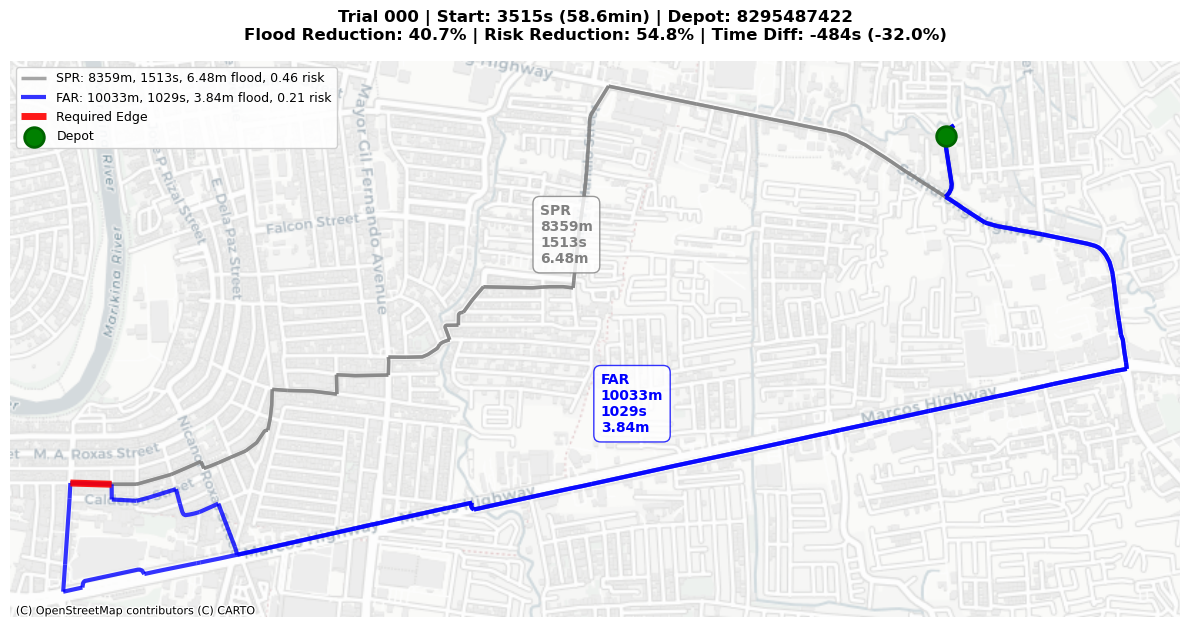

✓ Visualized trial 000
  Flood Reduction: 40.7%
  Risk Reduction: 54.8%
  Time Difference: -484s (-32.0%)



/var/folders/t8/3_98cbvs511926xzgzrr86140000gn/T/ipykernel_4717/1763532598.py:137: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mid = gdf.unary_union.centroid


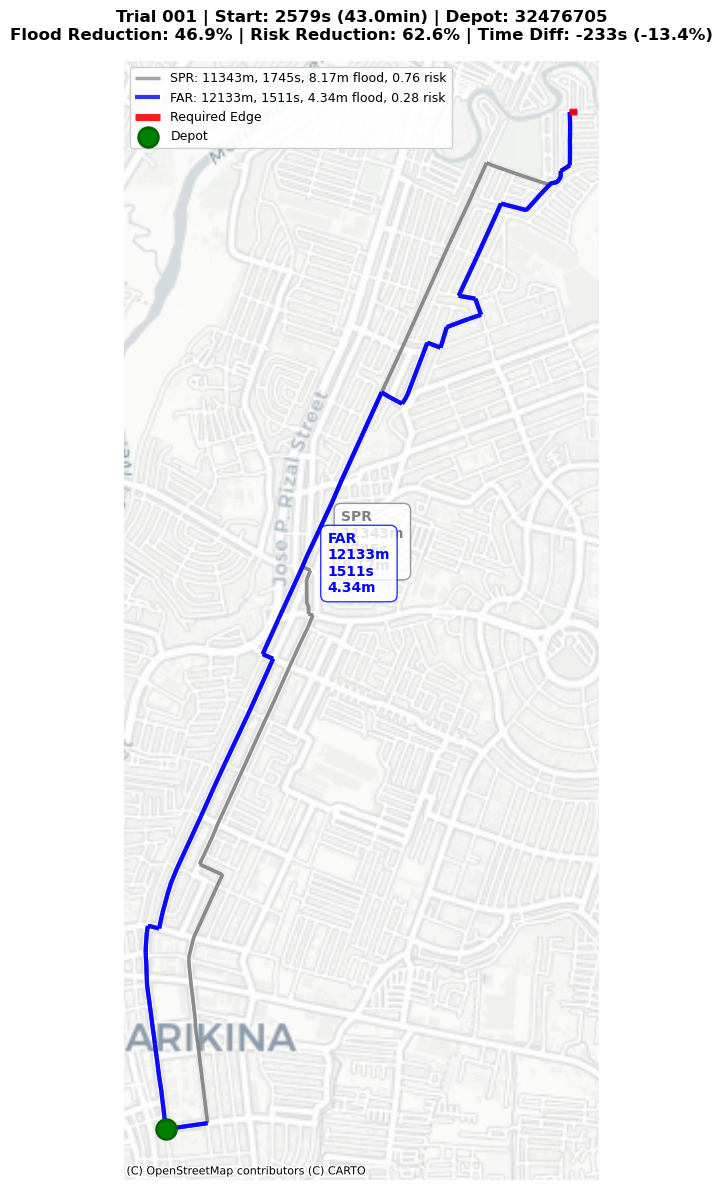

✓ Visualized trial 001
  Flood Reduction: 46.9%
  Risk Reduction: 62.6%
  Time Difference: -233s (-13.4%)



/var/folders/t8/3_98cbvs511926xzgzrr86140000gn/T/ipykernel_4717/1763532598.py:137: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mid = gdf.unary_union.centroid
/opt/anaconda3/envs/warp2025/lib/python3.9/site-packages/shapely/set_operations.py:421: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


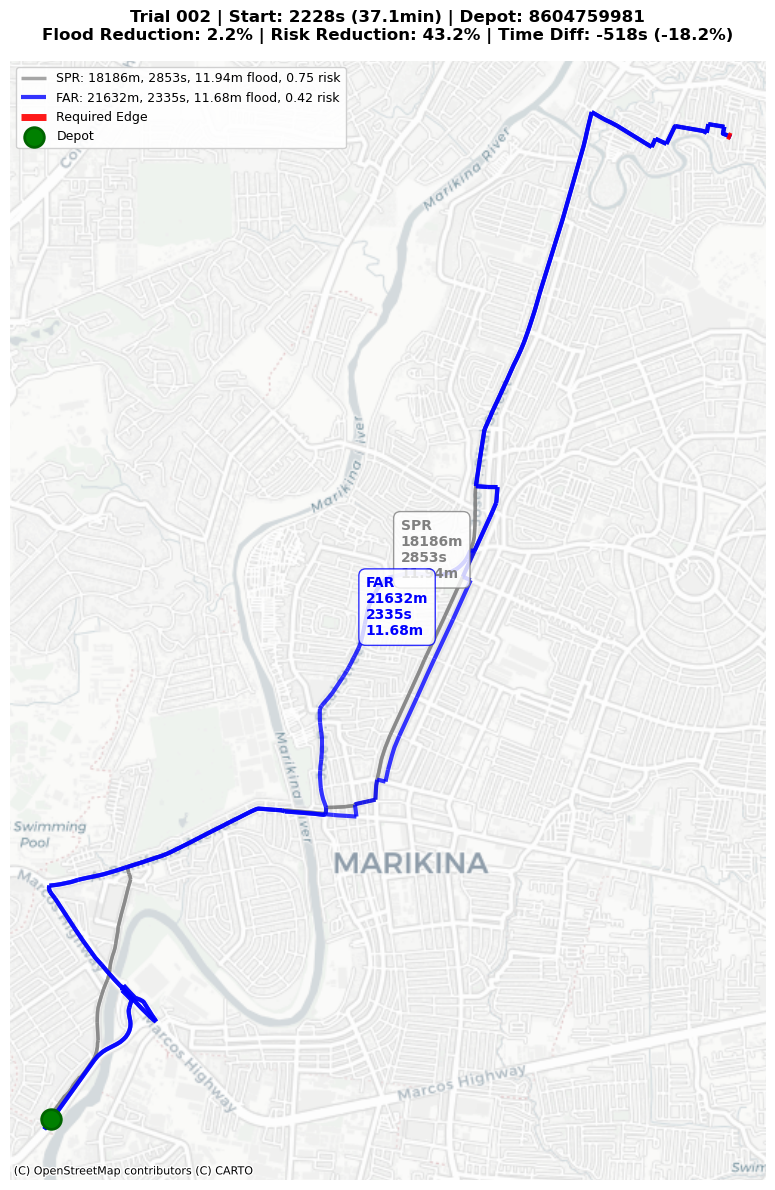

✓ Visualized trial 002
  Flood Reduction: 2.2%
  Risk Reduction: 43.2%
  Time Difference: -518s (-18.2%)



In [11]:
# -------------------------------------------------------------------------
# 2. Visualize comparisons
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("VISUALIZING ROUTE COMPARISONS")
print("="*70 + "\n")

compare_far_vs_spr_plot(
    result_dir='batch_results',
    n=3,  # Visualize first 3 trials
    base_color='gray',
    flood_color='blue'
)


In [ ]:
def visualize_single_route(route_csv_path, full_network_df, result_dir='batch_results', 
                          output_gif=None):
    """
    Create animated GIF for a single route using the correct global_start_time from experiment.
    
    Args:
        route_csv_path: Path to route CSV file (e.g., 'batch_results/trial_001_floodaware.csv')
        full_network_df: DataFrame with full road network and flood data
        result_dir: Directory containing experiment_summary.csv
        output_gif: Output GIF filename (auto-generated if None)
    
    Returns:
        Path to generated GIF file
    """
    # Extract trial ID from filename
    import re
    match = re.search(r'trial_(\d+)', route_csv_path)
    if not match:
        print("Could not extract trial ID from filename")
        return None
    
    trial_id = match.group(1)
    trial_num = int(trial_id) + 1  # trial_000 is Trial 1
    
    # Load experiment summary to get the correct global_start_time
    summary_path = os.path.join(result_dir, 'experiment_summary.csv')
    if not os.path.exists(summary_path):
        print(f"{summary_path} not found. Cannot determine global_start_time.")
        return None
    
    df_summary = pd.read_csv(summary_path)
    trial_row = df_summary[df_summary['Trial'] == trial_num]
    
    if trial_row.empty:
        print(f"Trial {trial_num} not found in summary.")
        return None
    
    global_start_time = int(trial_row['Start_Time_Sec'].iloc[0])
    
    # Auto-generate output filename if not provided
    if output_gif is None:
        route_type = 'floodaware' if 'floodaware' in route_csv_path else 'shortest'
        output_gif = os.path.join(result_dir, f'animation_trial_{trial_id}_{route_type}.gif')
    
    # Load route data
    route_gdf = pd.read_csv(route_csv_path)
    
    if route_gdf.empty:
        print(f"Route CSV is empty for trial {trial_num}")
        return None
    
    # Build a minimal graph (just for router initialization)
    G = build_graph_from_dataframe(full_network_df)
    
    # Create router instance
    router = FloodAwareRouter(df_edges=full_network_df, G=G)
    
    print(f"Creating animation for Trial {trial_num}...")
    print(f"  Using global_start_time: {global_start_time}s ({global_start_time/60:.1f} min)")
    print(f"  Route segments: {len(route_gdf)}")
    
    # Generate visualization
    router.visualize_route_as_gif(
        route_gdf=route_gdf,
        full_network_df=full_network_df,
        filename=output_gif,
        global_start_time=global_start_time
    )
    
    print(f"✓ Animation saved: {output_gif}\n")
    return output_gif


In [13]:
# -------------------------------------------------------------------------
# 3. Create animations for routes
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("CREATING ROUTE ANIMATIONS")
print("="*70 + "\n")

# Option A: Single route animation
visualize_single_route(
    route_csv_path='batch_results/trial_001_floodaware.csv',
    full_network_df=df,
    result_dir='batch_results'
)


CREATING ROUTE ANIMATIONS

Creating animation for Trial 2...
  Using global_start_time: 2579s (43.0 min)
  Route segments: 104


/var/folders/t8/3_98cbvs511926xzgzrr86140000gn/T/ipykernel_4717/1393379216.py:448: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(f))


🎞️ Route animation saved as: batch_results/animation_trial_001_floodaware.gif
✓ Animation saved: batch_results/animation_trial_001_floodaware.gif



'batch_results/animation_trial_001_floodaware.gif'

In [14]:
# -------------------------------------------------------------------------
# 4. Analyze results
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("RESULTS ANALYSIS")
print("="*70)

if len(summary_df) > 0:
    print(f"\n📊 Summary Statistics (n={len(summary_df)} trials):")
    print(f"\nFlood-Aware Route (FAR):")
    print(f"  Average Travel Time: {summary_df['FAR_Travel_Time'].mean():.1f} ± {summary_df['FAR_Travel_Time'].std():.1f}s")
    print(f"  Average Flood Risk:  {summary_df['FAR_Flood_Risk'].mean():.3f} ± {summary_df['FAR_Flood_Risk'].std():.3f}")
    print(f"  Average Flood Exposure: {summary_df['FAR_Cumulative_Flood'].mean():.2f} ± {summary_df['FAR_Cumulative_Flood'].std():.2f}m")
    
    print(f"\nShortest Path Route (SPR):")
    print(f"  Average Travel Time: {summary_df['SPR_Travel_Time'].mean():.1f} ± {summary_df['SPR_Travel_Time'].std():.1f}s")
    print(f"  Average Flood Risk:  {summary_df['SPR_Flood_Risk'].mean():.3f} ± {summary_df['SPR_Flood_Risk'].std():.3f}")
    print(f"  Average Flood Exposure: {summary_df['SPR_Cumulative_Flood'].mean():.2f} ± {summary_df['SPR_Cumulative_Flood'].std():.2f}m")
    
    print(f"\nImprovements (FAR vs SPR):")
    print(f"  Average Risk Reduction:  {summary_df['Flood_Risk_Improvement_Pct'].mean():.1f}%")
    print(f"  Average Flood Reduction: {summary_df['Cumulative_Flood_Improvement_Pct'].mean():.1f}%")
    print(f"  Average Time Difference: {summary_df['Travel_Time_Improvement_Pct'].mean():.1f}%")
    
    print(f"\n✅ FAR performs better in {(summary_df['Flood_Risk_Improvement_Pct'] > 0).sum()}/{len(summary_df)} trials")


RESULTS ANALYSIS

📊 Summary Statistics (n=10 trials):

Flood-Aware Route (FAR):
  Average Travel Time: 1414.7 ± 635.2s
  Average Flood Risk:  0.246 ± 0.131
  Average Flood Exposure: 4.64 ± 3.50m

Shortest Path Route (SPR):
  Average Travel Time: 1674.1 ± 736.2s
  Average Flood Risk:  0.457 ± 0.248
  Average Flood Exposure: 6.39 ± 3.88m

Improvements (FAR vs SPR):
  Average Risk Reduction:  42.2%
  Average Flood Reduction: 22.9%
  Average Time Difference: 17.4%

✅ FAR performs better in 10/10 trials
